In [4]:
import re
import os
import sys
import datetime
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.tsa.api as smt

from matplotlib.pylab import rcParams
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.figsize'] = (18, 5)
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

pd.options.display.max_columns = 25
pd.options.display.max_rows = 25
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats as scs
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image
from datetime import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error

#### Visualizar la demanda como serie de tiempo

In [5]:
#serie de tiempo en grafico
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

#leer la data del excel de los huespedes.csv
demand_data = pd.read_csv('./data/DemandaInfo.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)

#guardar en otra variable
demand_ts = demand_data['demand']

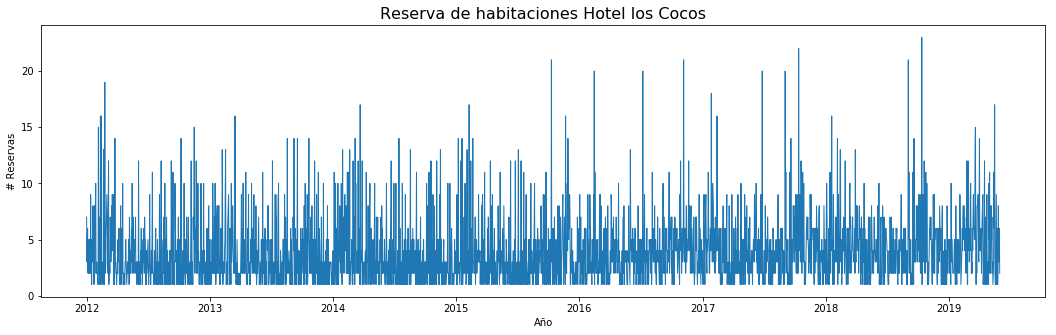

In [6]:
#Plot
plt.plot(demand_ts, linewidth=1)
plt.title(u'Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel(u'# Reservas')
plt.xlabel(u'Año')
plt.show()

In [7]:
demand_ts

time
2012-01-01    7
2012-01-02    3
2012-01-03    5
2012-01-04    6
2012-01-05    2
2012-01-06    3
2012-01-07    2
2012-01-08    5
2012-01-09    2
2012-01-10    5
2012-01-11    5
2012-01-12    2
             ..
2019-05-20    5
2019-05-21    9
2019-05-22    1
2019-05-23    6
2019-05-24    3
2019-05-25    1
2019-05-26    2
2019-05-27    8
2019-05-28    3
2019-05-29    4
2019-05-30    6
2019-05-31    2
Name: demand, Length: 2706, dtype: int64

#### Analizis de la Serie

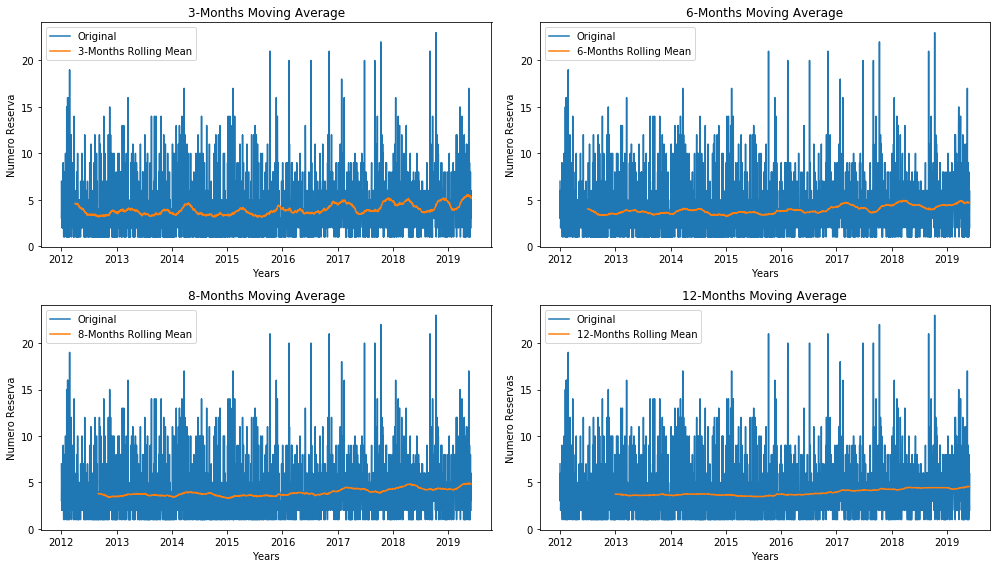

In [8]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(demand_ts.index, demand_ts, label='Original')
axes[0][0].plot(demand_ts.index, demand_ts.rolling(window=91).mean(), label='3-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Numero Reserva")
axes[0][0].set_title("3-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(demand_ts.index, demand_ts, label='Original')
axes[0][1].plot(demand_ts.index, demand_ts.rolling(window=183).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Numero Reserva")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(demand_ts.index, demand_ts, label='Original')
axes[1][0].plot(demand_ts.index, demand_ts.rolling(window=243).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Numero Reserva")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(demand_ts.index, demand_ts, label='Original')
axes[1][1].plot(demand_ts.index, demand_ts.rolling(window=365).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Numero Reservas")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

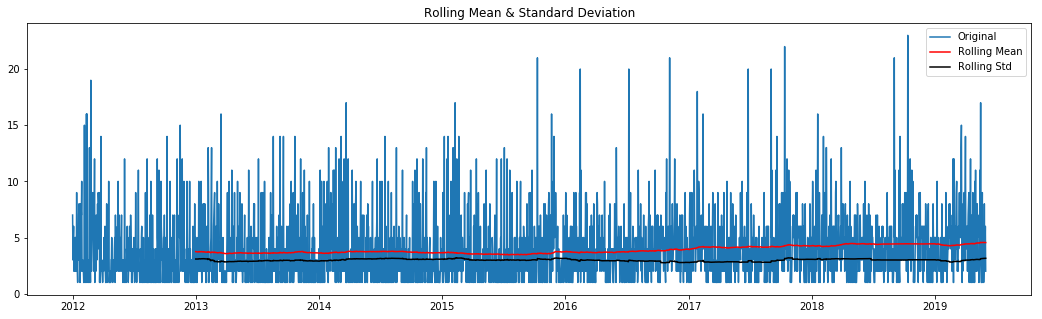

In [9]:
#Determing rolling statistics
rolmean = demand_ts.rolling(window=365).mean()
rolstd = demand_ts.rolling(window=365).std()

#Plot rolling statistics:
orig = plt.plot(demand_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean',color='red')
std = plt.plot(rolstd, label = 'Rolling Std',color='black')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [10]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(demand_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -8.70653
p-value                          0.00000
#lags Used                      16.00000
Number of Observations Used   2689.00000
Critical Value (1%)             -3.43278
Critical Value (5%)             -2.86262
Critical Value (10%)            -2.56734
dtype: float64


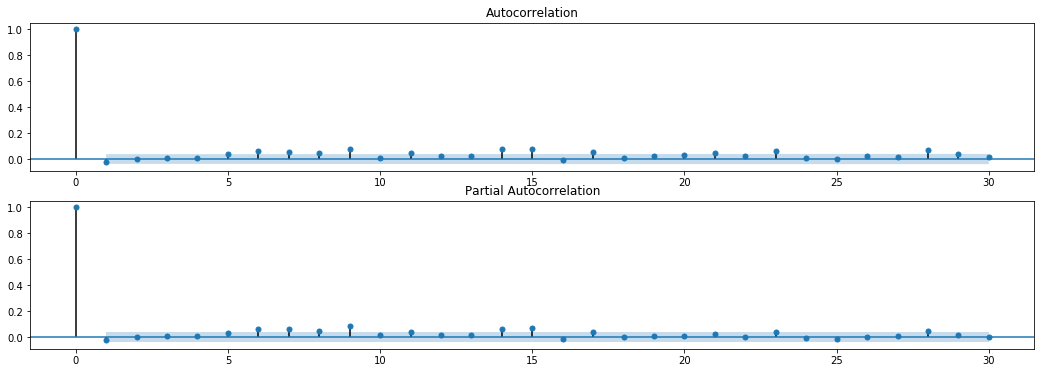

<Figure size 1296x360 with 0 Axes>

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure(figsize=(18, 6))
pyplot.subplot(211)
plot_acf(demand_ts, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(demand_ts, ax=pyplot.gca(), lags = 30)
pyplot.show()
plt.tight_layout()

#### Time Series Decomposition

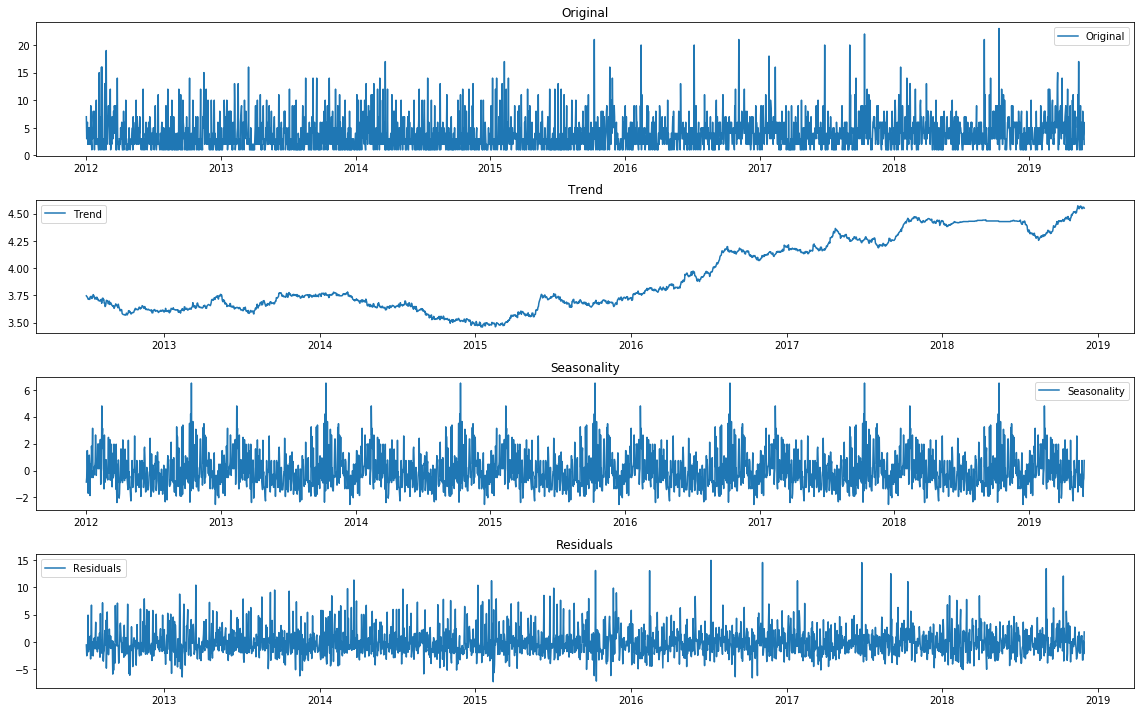

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(demand_ts, freq=365)

plt.figure(figsize = (16,10))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.title('Original')
plt.plot(demand_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.title('Trend')
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.title('Seasonality')
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.title('Residuals')
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#### Log transformation para hacer que los datos sean estacionarios en varianza

Text(0, 0.5, 'Demand')

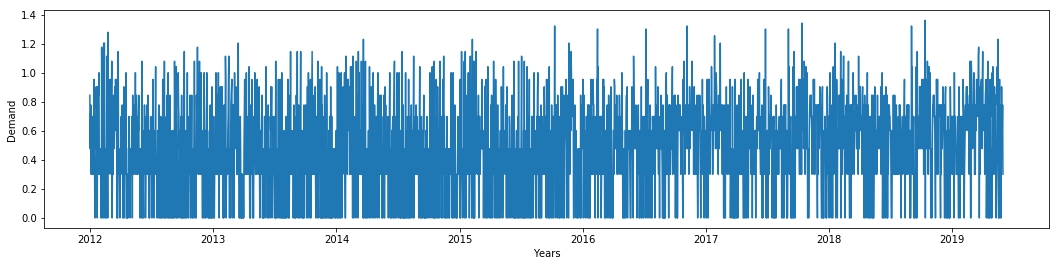

In [13]:
demand_ts_log = np.log10(demand_ts)
demand_ts_log.dropna(inplace=True)

plt.figure(figsize = (18,4))
plt.plot(demand_ts_log)
plt.xlabel('Years')
plt.ylabel('Demand')

#### Difference log transform para hacer que los datos sean estacionarios tanto en la media como en varianza

Text(0, 0.5, 'Demand')

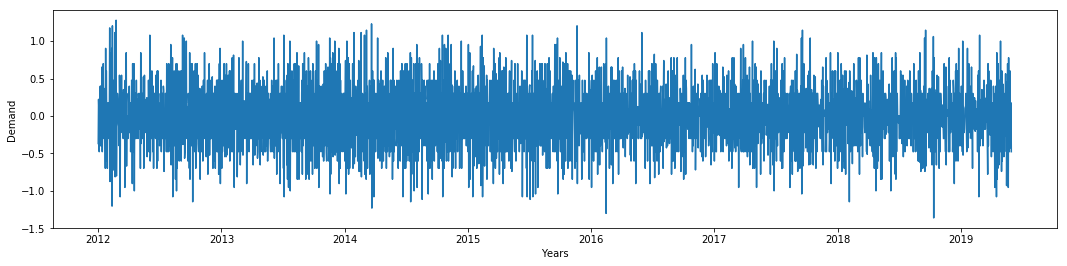

In [14]:
demand_ts_log_diff = demand_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
demand_ts_log_diff.dropna(inplace=True)

plt.figure(figsize = (18,4))
plt.plot(demand_ts_log_diff)
plt.xlabel('Years')
plt.ylabel('Demand')

#### Plot ACF and PACF to identify potential AR and MA model

In [15]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(demand_ts_log_diff, nlags=40)
lag_pacf = pacf(demand_ts_log_diff, nlags=40, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

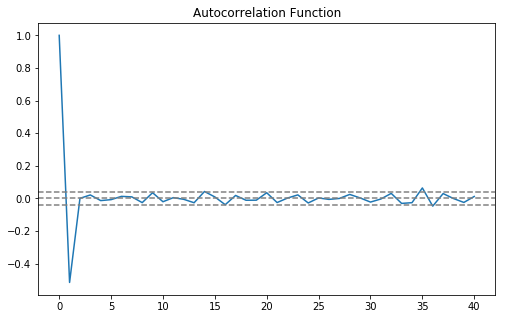

In [16]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(demand_ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(demand_ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

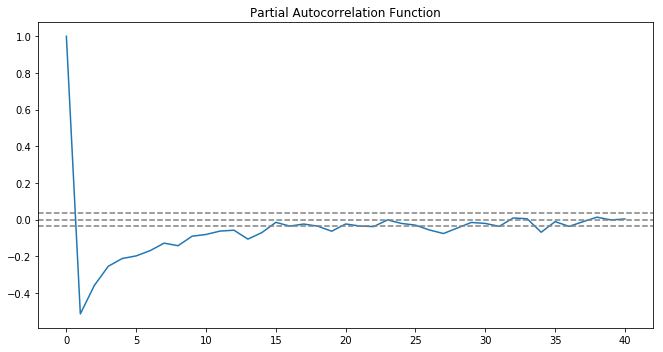

In [17]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(demand_ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(demand_ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

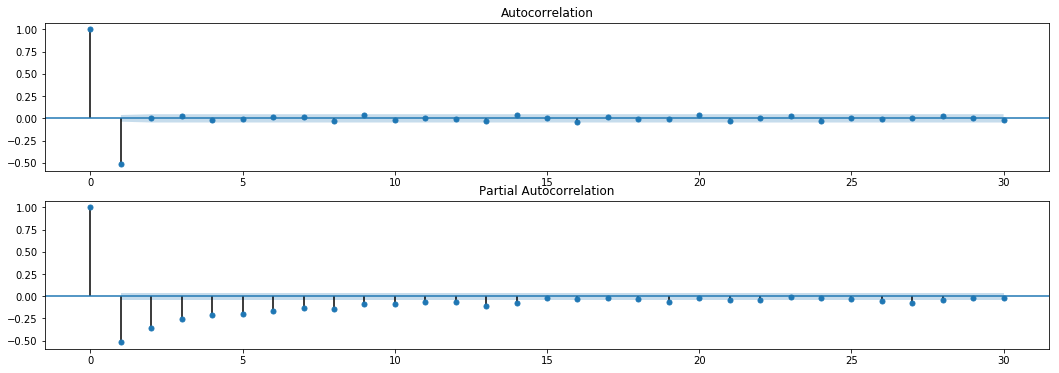

<Figure size 1296x360 with 0 Axes>

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure(figsize=(18, 6))
pyplot.subplot(211)
plot_acf(demand_ts_log_diff, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(demand_ts_log_diff, ax=pyplot.gca(), lags = 30)
pyplot.show()
plt.tight_layout()

#### Identificación del mejor modelo de ajuste ARIMA

In [23]:
#Dividir datos de prueba y entrenamiento
train = demand_ts[:'2018']
test = demand_ts['2019':]

print(len(train))
print(len(test))

2555
151


In [20]:
best_model = sm.tsa.statespace.SARIMAX(demand_ts,
                                      order=(3, 1, 1),
                                      seasonal_order=(0, 1, 1, 52),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [21]:
print(best_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             demand   No. Observations:                 2706
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -6645.269
Date:                            Fri, 05 Jul 2019   AIC                          13302.539
Time:                                    22:23:45   BIC                          13337.716
Sample:                                         0   HQIC                         13315.284
                                           - 2706                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0585      0.023     -2.585      0.010      -0.103      -0.014
ar.L2         -0.0422      0.020   

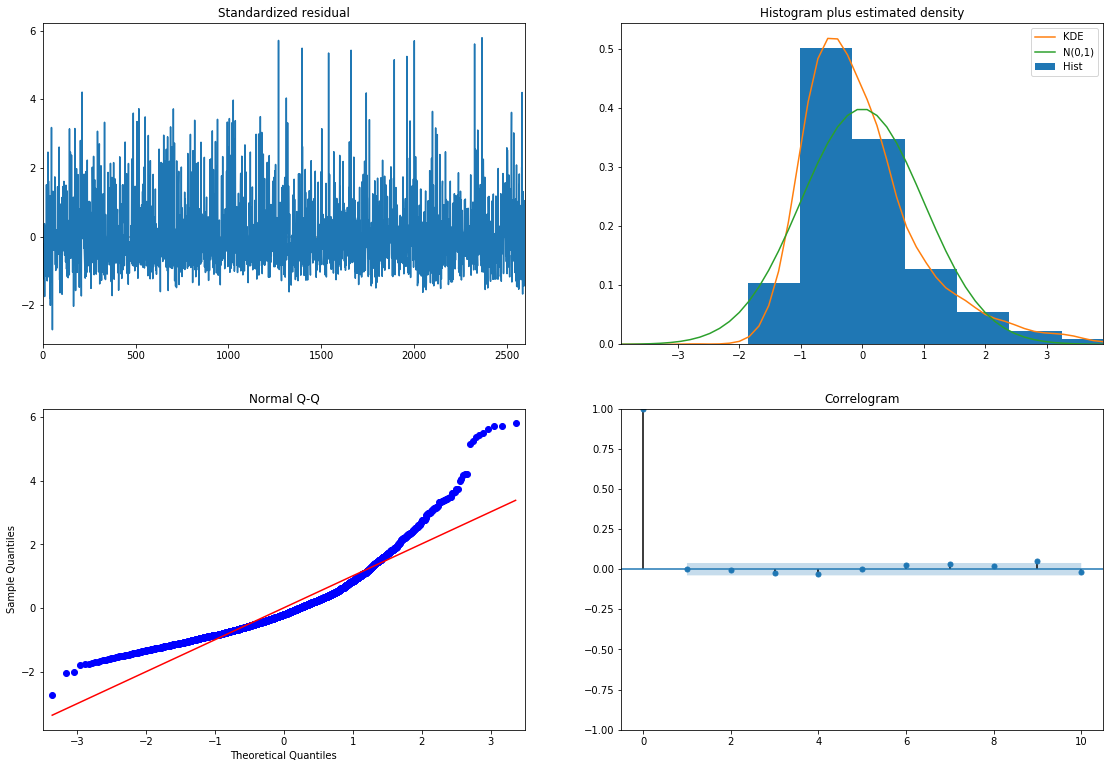

In [22]:
best_results.plot_diagnostics(figsize=(19, 13))
plt.show()

#### Predict demand on in-sample date using the best fit ARIMA model

In [37]:
pred = best_results.get_prediction(start=2555, dynamic=False)
pred_ci = pred.conf_int()

In [50]:
pred.predicted_mean

time
2019-01-01   4.72408
2019-01-02   4.08957
2019-01-03   4.53035
2019-01-04   3.65346
2019-01-05   3.93131
2019-01-06   4.78835
2019-01-07   3.94751
2019-01-08   3.83920
2019-01-09   4.57064
2019-01-10   4.03735
2019-01-11   4.63347
2019-01-12   4.28202
2019-01-13   4.43842
2019-01-14   4.70957
2019-01-15   4.47947
2019-01-16   3.96747
2019-01-17   4.71723
2019-01-18   3.77739
2019-01-19   4.53814
2019-01-20   4.34778
2019-01-21   4.18210
2019-01-22   3.76605
2019-01-23   4.13583
2019-01-24   4.97091
2019-01-25   4.05785
2019-01-26   3.58384
2019-01-27   3.16372
2019-01-28   3.53720
2019-01-29   4.02688
2019-01-30   3.51477
2019-01-31   3.82509
2019-02-01   3.18469
2019-02-02   3.39387
2019-02-03   3.38144
2019-02-04   4.17297
2019-02-05   4.28442
2019-02-06   3.83189
2019-02-07   4.02529
2019-02-08   3.29350
2019-02-09   3.90503
2019-02-10   4.03638
2019-02-11   3.65186
2019-02-12   3.31628
2019-02-13   3.35524
2019-02-14   3.21576
2019-02-15   4.12814
2019-02-16   3.94056
2019-02-

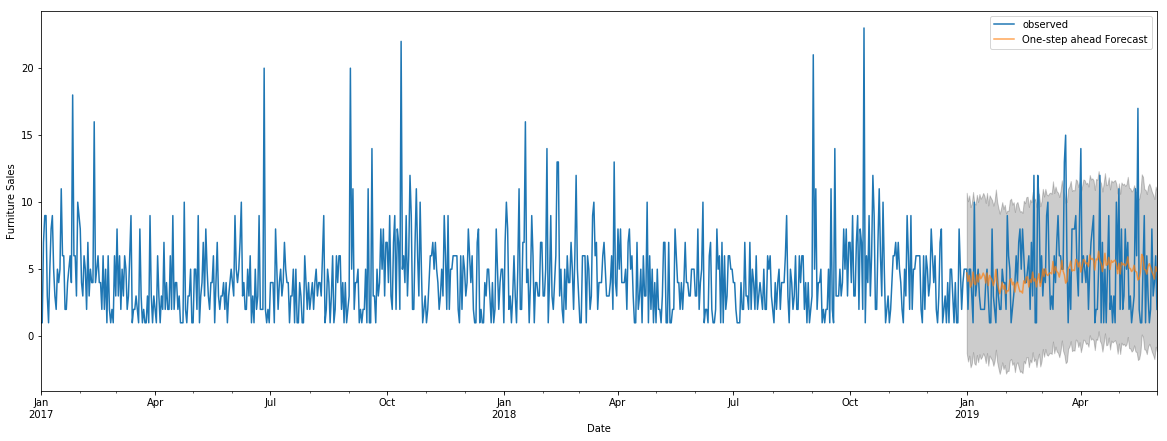

<Figure size 1296x360 with 0 Axes>

In [39]:
ax = demand_ts['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()
plt.tight_layout()

#### Forecast sales using the best fit ARIMA model

In [40]:
FORECAST = 182
pred_uc = best_results.get_forecast(steps=FORECAST)
pred_ci = pred_uc.conf_int()

In [41]:
futureDates = pd.date_range(start = '2019-05-26', periods=FORECAST, freq='W')
pred_ci.index = futureDates
mean= pred_uc.predicted_mean

In [42]:
futureDF = pd.DataFrame(mean.values, index=futureDates)
futureDF

,0
2019-05-26,5.20155
2019-06-02,5.15550
2019-06-09,4.21404
2019-06-16,4.75777
2019-06-23,4.53202
2019-06-30,5.30223
2019-07-07,4.91744
2019-07-14,4.85968
2019-07-21,4.18661
2019-07-28,4.60969


Text(0.5, 0.98, 'Demand Forecast')

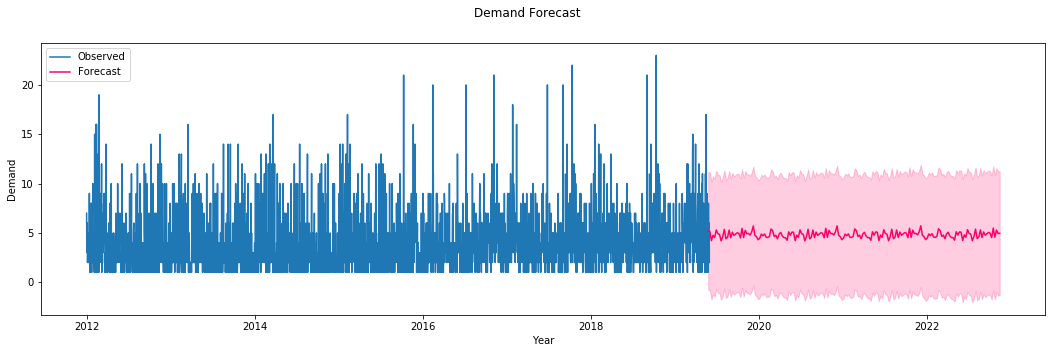

In [43]:
fig,ax = plt.subplots()
ax.plot(demand_ts, label="Observed")
ax.plot(futureDF, label='Forecast', color='#ff0066');

  # draw confidence bound
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.2);
 
ax.set_xlabel("Year")
ax.set_ylabel("Demand") 
ax.legend(loc='upper left')
fig.suptitle("Demand Forecast")

In [44]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
mean_absolute_percentage_error(test, pred.predicted_mean)

95.65313513439953

In [48]:
pd.set_option('display.max_columns', 3000)
pd.options.display.max_columns = 1600
pd.options.display.max_rows = 1600

futureDF

,0
2019-05-26,5.20155
2019-06-02,5.15550
2019-06-09,4.21404
2019-06-16,4.75777
2019-06-23,4.53202
2019-06-30,5.30223
2019-07-07,4.91744
2019-07-14,4.85968
2019-07-21,4.18661
2019-07-28,4.60969


In [51]:
test

time
2019-01-01     5
2019-01-02     2
2019-01-03     5
2019-01-04     5
2019-01-05     3
2019-01-06     1
2019-01-07    10
2019-01-08     3
2019-01-09     4
2019-01-10     5
2019-01-11     3
2019-01-12     2
2019-01-13     2
2019-01-14     2
2019-01-15     2
2019-01-16     4
2019-01-17     5
2019-01-18     3
2019-01-19     1
2019-01-20     1
2019-01-21     8
2019-01-22     3
2019-01-23     2
2019-01-24     1
2019-01-25     5
2019-01-26     3
2019-01-27     2
2019-01-28     2
2019-01-29     5
2019-01-30     4
2019-01-31     4
2019-02-01     2
2019-02-02     9
2019-02-03     6
2019-02-04     5
2019-02-05     1
2019-02-06     2
2019-02-07     3
2019-02-08     4
2019-02-09     6
2019-02-10     4
2019-02-11     7
2019-02-12     8
2019-02-13     5
2019-02-14     8
2019-02-15     6
2019-02-16     4
2019-02-17     4
2019-02-18     5
2019-02-19     6
2019-02-20     2
2019-02-21     7
2019-02-22     3
2019-02-23    12
2019-02-24     1
2019-02-25     1
2019-02-26    12
2019-02-27    10
2019-02-2